**CHANGELOG**
- read data from instant .csv
- add more feature engineering that make our more complexity

## Import Libraries

In [370]:
import numpy as np
import pandas as pd
from typing import Tuple
import pandas_ta as ta

# visualization
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import mplfinance as mpf

# backtesting library
import vectorbt as vbt

# machine learning
from sklearn.model_selection import (
    TimeSeriesSplit,
    cross_val_score,
    GridSearchCV,
    cross_val_predict,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

# get data from TradingView
from tvDatafeed import TvDatafeed, Interval

tv = TvDatafeed()

## Import Data

In [371]:
raw_df = pd.read_csv("BTC_1H.csv", index_col="datetime")

# set index type as "datetime64[ns]"
raw_df.index = pd.to_datetime(raw_df.index)
raw_df

,symbol,open,high,low,close,volume
datetime,,,,,,
2022-01-01 07:00:00,BINANCE:BTCUSDT,46216.93,46731.39,46208.37,46656.13,1503.33095
2022-01-01 08:00:00,BINANCE:BTCUSDT,46656.14,46949.99,46574.06,46778.14,943.81539
2022-01-01 09:00:00,BINANCE:BTCUSDT,46778.14,46928.94,46721.96,46811.77,485.16860
2022-01-01 10:00:00,BINANCE:BTCUSDT,46811.77,46916.63,46760.12,46813.20,562.88971
2022-01-01 11:00:00,BINANCE:BTCUSDT,46813.21,46887.33,46591.23,46711.05,861.88389
...,...,...,...,...,...,...
2023-05-30 10:00:00,BINANCE:BTCUSDT,27783.43,27940.55,27773.69,27829.23,1430.88893
2023-05-30 11:00:00,BINANCE:BTCUSDT,27829.23,27848.09,27760.38,27776.19,733.62881
2023-05-30 12:00:00,BINANCE:BTCUSDT,27776.18,27776.19,27672.93,27753.38,969.42806


## Add technical indicators

In [372]:
strategy_name = "Demo Strategy"
strategy1 = ta.Strategy(
    name="Demo Strategy",
    description="",
    ta=[
        {"kind": "adx", "length": 14, "col_names": ("ADX_14", "DMP_14", "DMN_14")},
        {
            "kind": "bbands",
            "length": 20,
            "std": 3,
            "col_names": ("BBL", "BBM", "BBU", "BBB", "BBP"),
        },
        {"kind": "ema", "length": 50},
        {"kind": "ema", "length": 100},
        {"kind": "ema", "length": 200},
        {
            "kind": "donchian",
            "lower_length": 12,
            "upper_length": 24,
            "col_names": ("DCL", "DCM", "DCU"),
        },
        {
            "kind": "macd",
            "fast": 12,
            "slow": 26,
            "col_names": ("MACD", "MACD_H", "MACD_S"),
        },
    ],
)

strat1 = raw_df.copy()
strat1.ta.strategy(strategy1)

strat1.head(5)

,symbol,open,high,low,close,volume,ADX_14,DMP_14,DMN_14,BBL,...,BBP,EMA_50,EMA_100,EMA_200,DCL,DCM,DCU,MACD,MACD_H,MACD_S
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 07:00:00,BINANCE:BTCUSDT,46216.93,46731.39,46208.37,46656.13,1503.33095,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 08:00:00,BINANCE:BTCUSDT,46656.14,46949.99,46574.06,46778.14,943.81539,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 09:00:00,BINANCE:BTCUSDT,46778.14,46928.94,46721.96,46811.77,485.16860,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 10:00:00,BINANCE:BTCUSDT,46811.77,46916.63,46760.12,46813.20,562.88971,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 11:00:00,BINANCE:BTCUSDT,46813.21,46887.33,46591.23,46711.05,861.88389,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## EDA

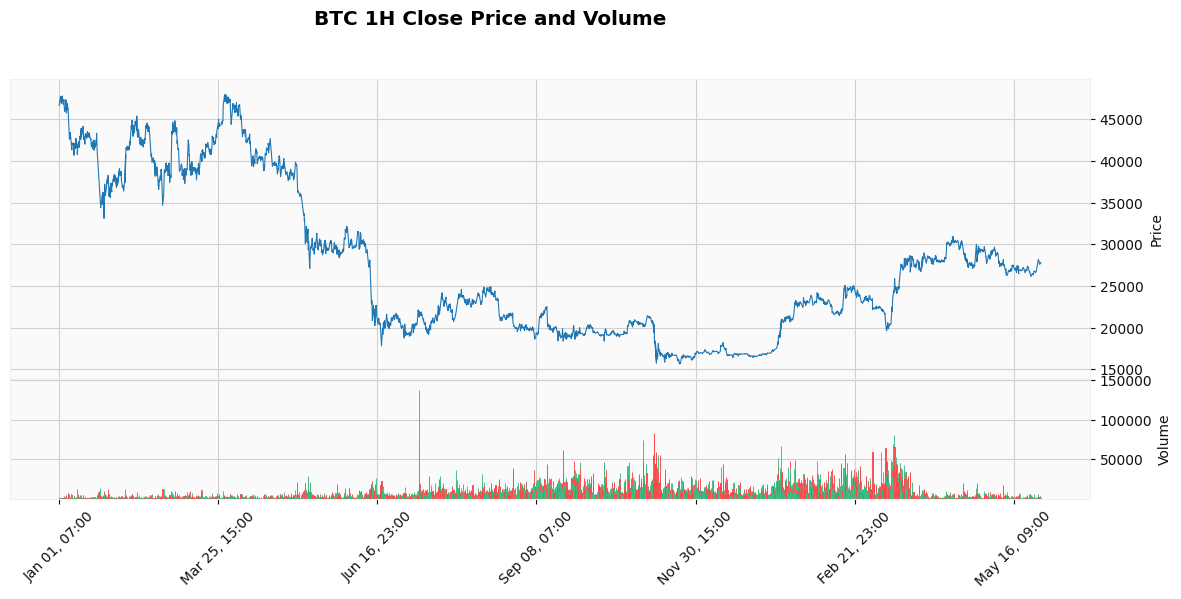

In [374]:
# Create a new figure
fig, axes = mpf.plot(
    strat1,
    type="line",
    volume=True,
    style="yahoo",
    figsize=(15, 6),
    title="BTC 1H Close Price and Volume",
    ylabel="Price",
    returnfig=True,
)

In [375]:
# Create figure and specify size
fig = go.Figure()

# Add line plots
fig.add_trace(
    go.Scatter(x=strat1.index, y=strat1["close"], mode="lines", name="Close Price")
)
fig.add_trace(
    go.Scatter(x=strat1.index, y=strat1["EMA_50"], mode="lines", name="EMA_50")
)
fig.add_trace(
    go.Scatter(x=strat1.index, y=strat1["EMA_100"], mode="lines", name="EMA_100")
)
fig.add_trace(
    go.Scatter(x=strat1.index, y=strat1["EMA_200"], mode="lines", name="EMA_200")
)

# Set the layout
fig.update_layout(
    title="BTC 1H Close Price", xaxis=dict(title="Time"), yaxis=dict(title="Price")
)

# Display the plot
fig.show()

In [376]:
def create_feature(df: pd.DataFrame) -> pd.DataFrame:
    df["ADX_trend"] = np.where(
        np.isnan(df["ADX_14"]), df["ADX_14"], np.where(df["ADX_14"] > 25, 1, 0)
    )
    df["DCU_uptrend"] = ta.cross_value(
        df["high"], df["DCU"].shift(), above=True, asint=False
    ).astype(int)
    df["DCU_downtrend"] = ta.cross_value(
        df["low"], df["DCL"].shift(), above=False, asint=False
    ).astype(int)
    df["MACD_trend"] = np.where(
        np.isnan(df["MACD"]), df["MACD"], np.where(df["MACD"] > 0, 1, 0)
    )

    df["MACD_trend"] = np.where(
        np.isnan(df["MACD"]), df["MACD"], np.where(df["MACD"] > 0, 1, 0)
    )

    df["EMA_50_trend"] = np.where(
        np.isnan(df["EMA_50"]), df["EMA_50"], np.where(df["EMA_50"] > df["close"], 1, 0)
    )
    # close price more than EMA_50 more than n hrs
    # df['EMA_50_consec'] = np.where(df['EMA_50_trend'].rolling(window=2).mean() == 1
    #                     , 1
    #                     , 0)

    df["EMA_50_100_trend"] = np.where(
        np.isnan(df["EMA_50"]),
        df["EMA_50"],
        np.where(df["EMA_50"] > df["EMA_100"], 1, 0),
    )

    df["EMA_50_200_trend"] = np.where(
        np.isnan(df["EMA_50"]),
        df["EMA_50"],
        np.where(df["EMA_50"] > df["EMA_200"], 1, 0),
    )

    df["EMA_100_trend"] = np.where(
        np.isnan(df["EMA_100"]),
        df["EMA_100"],
        np.where(df["EMA_100"] > df["close"], 1, 0),
    )
    # close price more than EMA_100 more than n hrs
    # df['EMA_100_consec'] = np.where(df['EMA_100_trend'].rolling(window=2).mean() == 1
    #                     , 1
    #                     , 0)

    df["EMA_100_200_trend"] = np.where(
        np.isnan(df["EMA_100"]),
        df["EMA_100"],
        np.where(df["EMA_100"] > df["EMA_200"], 1, 0),
    )

    df["EMA_200_trend"] = np.where(
        np.isnan(df["EMA_200"]),
        df["EMA_200"],
        np.where(df["EMA_200"] > df["close"], 1, 0),
    )
    # # close price more than EMA_200 more than n hrs
    # df['EMA_200_consec'] = np.where(df['EMA_200_trend'].rolling(window=2).mean() == 1
    #                     , 1
    #                     , 0)
    return df


def create_y_label(df: pd.DataFrame, n_days: int) -> pd.DataFrame:
    """Create labels for the given DataFrame based on the future price movement.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the price data.
    n_days : int
        The number of days to look ahead for labeling.

    Returns
    -------
    pd.DataFrame
        The DataFrame with an additional column 'y' representing the labels.
    """
    return_s = df["close"].pct_change().shift(-n_days)
    df["y"] = np.where(np.isnan(return_s), return_s, np.where(return_s > 0, 1, 0))
    return df

## Data Cleaning

In [377]:
def num_split_data(
    data: pd.DataFrame,
    train_size: float,
    test_size: float,
    out_of_sample_size: float,
    n_splits: int,
) -> Tuple[int, int, int]:
    """
    Calculate the size of training, testing, and out-of-sample data for time series cross-validation.

    Parameters
    ----------
    data : pd.DataFrame
        A pandas DataFrame containing the time series data.
    train_size : float
        The proportion of the data to use for training.
    test_size : float
        The proportion of the data to use for testing.
    out_of_sample_size : float
        The proportion of the data to use for out-of-sample prediction.
    n_splits : int
        The number of folds to use for cross-validation.

    Returns
    -------
    Tuple[int, int, int]
        A tuple containing the sizes of the training, testing, and out-of-sample data.
    """
    # Calculate the size of out-of-sample data
    rows_out_of_sample = (len(data)) * out_of_sample_size

    # Calculate the size of train/test dat
    train_test_size = (len(data)) - rows_out_of_sample
    num_of_days = train_test_size / 24

    # Calculate the size of training and testing sets for each fold
    split_train_test_size = train_test_size // n_splits
    rows_train_size = round((split_train_test_size * train_size))
    rows_test_size = round((split_train_test_size * test_size))
    rows_out_of_sample = round(rows_out_of_sample)

    # Print the number of days, training size, and testing size for each fold
    print(f"Number of Days: {num_of_days}")
    print(f"Training Size for Each Fold: {rows_train_size}")
    print(f"Testing Size for Each Fold: {rows_test_size}")
    print(f"Out of Sample Size for Each Fold: {rows_out_of_sample}")

    return rows_train_size, rows_test_size, rows_out_of_sample

In [378]:
n_splits = 10

rows_train_size, rows_test_size, rows_out_of_sample = num_split_data(
    data=raw_df,
    train_size=0.80,
    test_size=0.20,
    out_of_sample_size=0.1,
    n_splits=n_splits,
)

Number of Days: 462.825
Training Size for Each Fold: 888
Testing Size for Each Fold: 222
Out of Sample Size for Each Fold: 1234


In [379]:
# add feature and label
df = create_feature(df=strat1)
df = create_y_label(df=df, n_days=7)

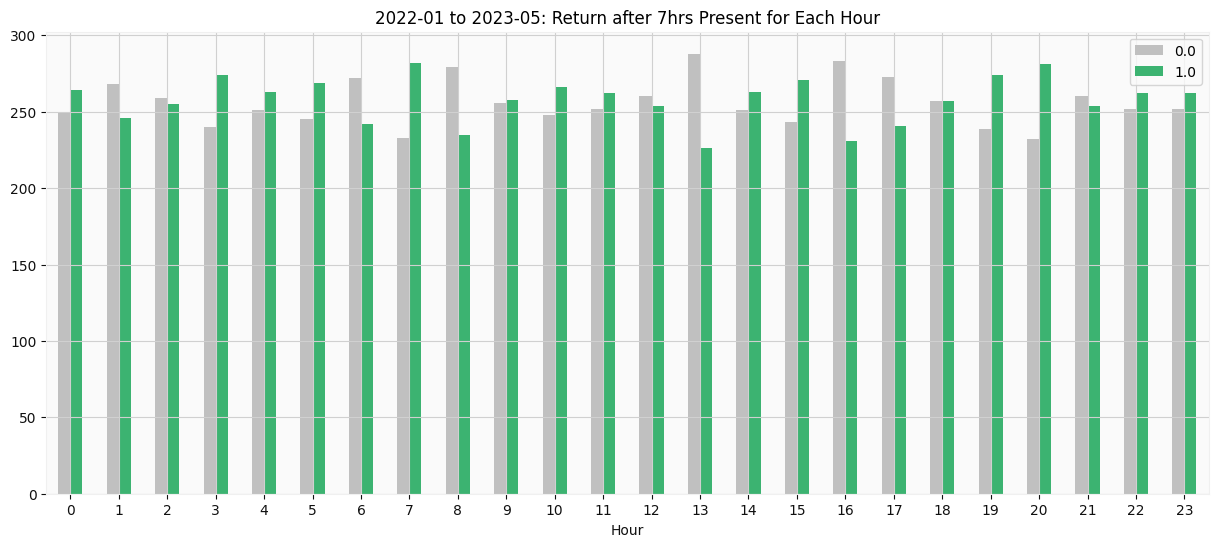

In [380]:
hours_count_df = df.groupby([df.index.hour, "y"])[["y"]].count().unstack()

hours_count_df.columns = hours_count_df.columns.droplevel()

hours_count_df.reset_index(inplace=True)
hours_count_df.drop(columns=["datetime"], axis=1, inplace=True)
hours_count_df.columns.name = None

start_date = df.index[0].strftime("%Y-%m")
end_date = df.index[-1].strftime("%Y-%m")

# visualization
ax = hours_count_df.plot(
    kind="bar",
    figsize=(15, 6),
    title=f"{start_date} to {end_date}: Return after 7hrs Present for Each Hour",
    color=["silver", "mediumseagreen"],
    xlabel="Hour",
)

plt.xticks(rotation=0)
plt.show()

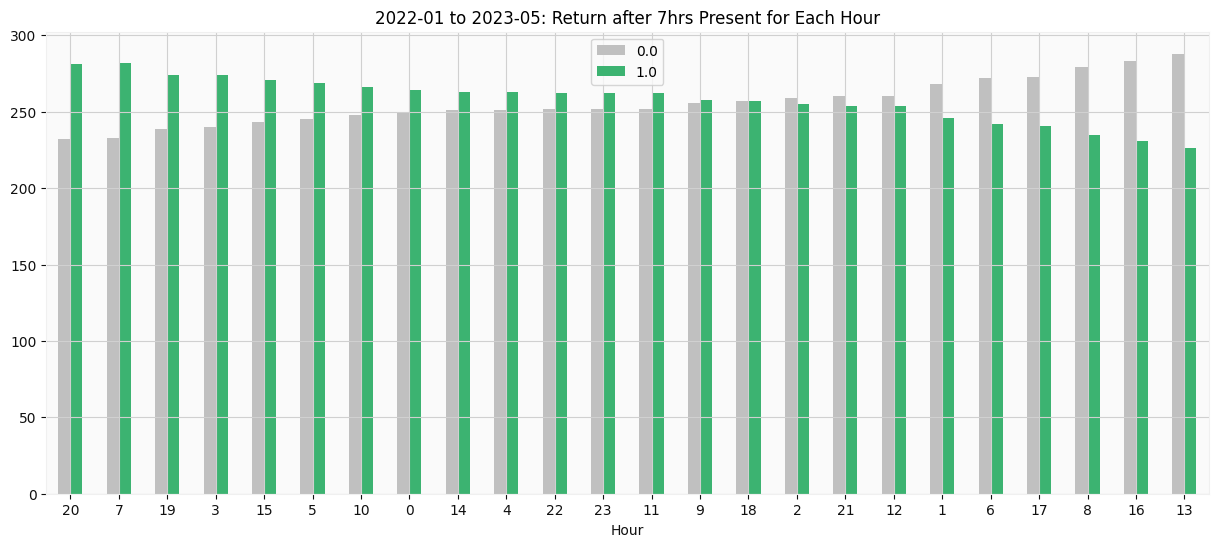

In [381]:
hours_count_df["diff"] = hours_count_df[1] - hours_count_df[0]

hours_count_df.sort_values("diff", ascending=False)[[0, 1]].plot(
    kind="bar",
    figsize=(15, 6),
    title=f"{start_date} to {end_date}: Return after 7hrs Present for Each Hour",
    color=["silver", "mediumseagreen"],
    xlabel="Hour",
)

plt.xticks(rotation=0)
plt.show()

Text(0.5, 0.98, 'Price directions for the next 7hrs during the period of 2022-01 to 2023-05')

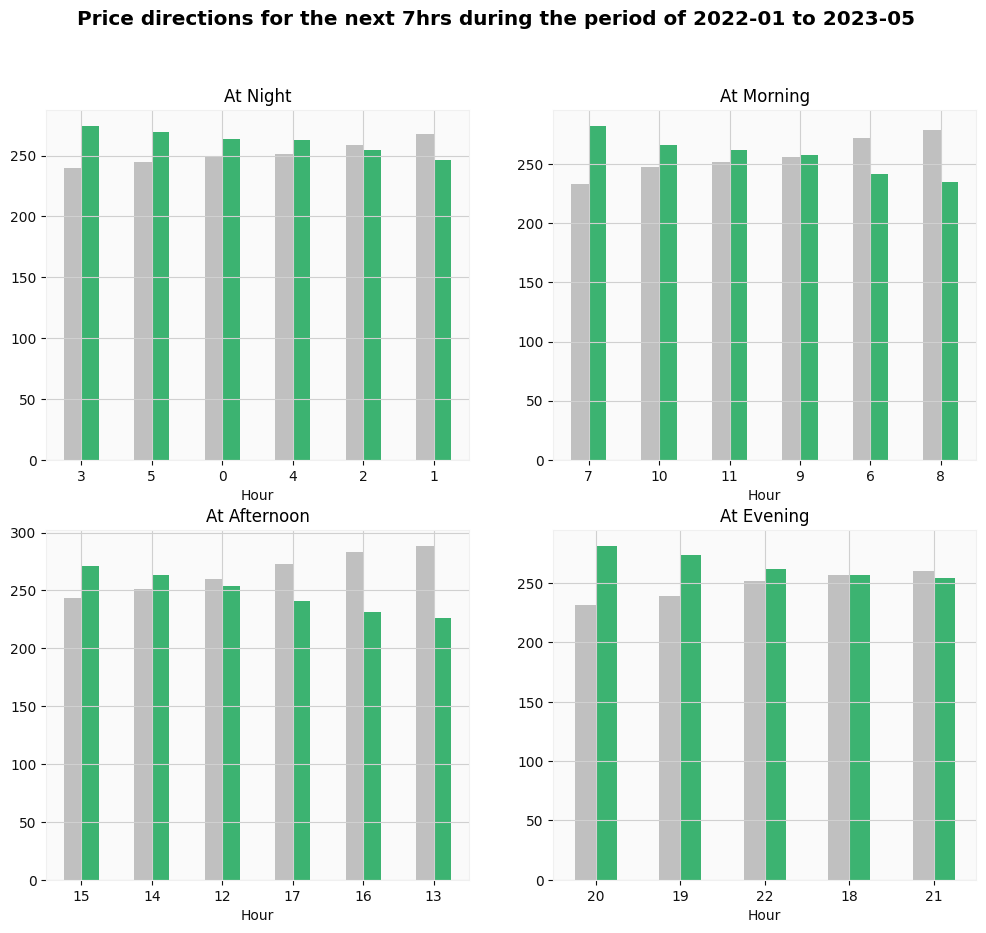

In [382]:
# Price direction 7hrs Group by Time Period
time_period_labels = ["Night", "Morning", "Afternoon", "Evening"]
hours_count_df["time_period"] = pd.cut(
    hours_count_df.index,
    bins=[0, 6, 12, 18, 23],
    labels=time_period_labels,
    right=False,
)

# Create a figure and subplots in a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Flatten the axes array
axes = axes.flatten()

# Iterate over each time period and plot the corresponding data
for i, label in enumerate(time_period_labels):
    ax = axes[i]
    df_label = hours_count_df[hours_count_df["time_period"] == label].sort_values(
        "diff", ascending=False
    )[[0, 1]]
    df_label.plot(
        kind="bar",
        ax=ax,
        title=f"At {label}",
        color=["silver", "mediumseagreen"],
        xlabel="Hour",
    )
    ax.legend().set_visible(False)  # Hide the legend for each subplot
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)  # set rotate

fig.suptitle(
    "Price directions for the next 7hrs during the period of 2022-01 to 2023-05"
)

**Ideas**
- feature เกี่ยวกับเวลาช่วงใดควรเล่น กับไม่ควรเล่น

In [383]:
# select feature
df_select_columns = df.iloc[:, 23:]  # except original indicators and OHLC
df_select_columns["close"] = df["close"]


df_select_columns.dropna(inplace=True)

X = df_select_columns.drop(columns=["close", "y"])
y = df_select_columns["y"]

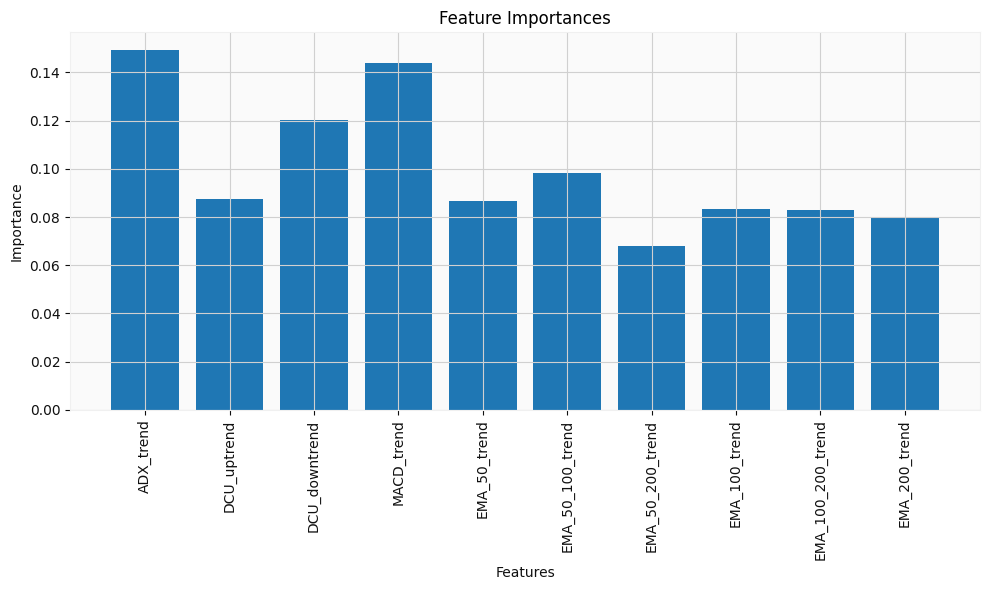

In [384]:
# Assuming you have features X and labels y
model = RandomForestClassifier()
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances, align="center")
plt.xticks(range(len(importances)), model.feature_names_in_, rotation="vertical")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

In [385]:
# The training and validation datasets are utilized to explore and determine the optimal methodology
# The testing dataset, which represents unseen data, is then used once the best result has been achieved on the training and validation datasets.
X_train_val, X_test = X.iloc[:-rows_out_of_sample], X.iloc[-rows_out_of_sample:]
y_train_val, y_test = y.iloc[:-rows_out_of_sample], y.iloc[-rows_out_of_sample:]

## Split Train/Validation Dataset

In [386]:
n_splits = 5

# training for 1 month
# week * hrs
train_size = 28 * 24

# validation for 1 week
test_size = 7 * 24

In [387]:
rf = RandomForestClassifier(random_state=42)

tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

# Perform cross-validation on the data
for k_fold, (X_train_val_index, y_train_val_index) in enumerate(
    tscv.split(X_train_val)
):
    # X_train_val = raw_indicators.iloc[X_train_val_index]
    # y_train_val = raw_indicators.iloc[y_train_val_index]
    train_data = X_train_val.iloc[X_train_val_index]
    test_data = X_train_val.iloc[y_train_val_index]
    print("--------------------")
    # number of fold
    print("Fold: ", k_fold + 1)
    # Print the shapes of the training and testing sets for each fold
    print("Training data shape:", train_data.shape)
    print("Testing data shape:", test_data.shape)

    # Print the period of the training and testing sets for each fold
    print("Training date:", train_data.index[0], "-", train_data.index[-1])
    print("Testing date:", test_data.index[0], "-", test_data.index[-1])

--------------------
Fold:  1
Training data shape: (10062, 10)
Testing data shape: (168, 10)
Training date: 2022-01-09 14:00:00 - 2023-03-04 19:00:00
Testing date: 2023-03-04 20:00:00 - 2023-03-11 19:00:00
--------------------
Fold:  2
Training data shape: (10230, 10)
Testing data shape: (168, 10)
Training date: 2022-01-09 14:00:00 - 2023-03-11 19:00:00
Testing date: 2023-03-11 20:00:00 - 2023-03-18 19:00:00
--------------------
Fold:  3
Training data shape: (10398, 10)
Testing data shape: (168, 10)
Training date: 2022-01-09 14:00:00 - 2023-03-18 19:00:00
Testing date: 2023-03-18 20:00:00 - 2023-03-25 21:00:00
--------------------
Fold:  4
Training data shape: (10566, 10)
Testing data shape: (168, 10)
Training date: 2022-01-09 14:00:00 - 2023-03-25 21:00:00
Testing date: 2023-03-25 22:00:00 - 2023-04-01 21:00:00
--------------------
Fold:  5
Training data shape: (10734, 10)
Testing data shape: (168, 10)
Training date: 2022-01-09 14:00:00 - 2023-04-01 21:00:00
Testing date: 2023-04-01 2

## Normalization

In [388]:
normalizers = [
    ("scaler", None),
    ("scaler", RobustScaler()),
    ("scaler", MinMaxScaler()),
    ("scaler", StandardScaler()),
]

for i, normalizer in enumerate(normalizers):
    pipeline = Pipeline([normalizer, ("rf", RandomForestClassifier(random_state=42))])

    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

    score = cross_val_score(
        pipeline, X_train_val, y_train_val, scoring="roc_auc", cv=tscv
    )
    print("---------------------------")
    print(f"Normalizer: {type(normalizers[i][1]).__name__}")
    print(
        "{}: {:.4f} +- {:.4f}".format(
            type(pipeline).__name__, score.mean(), score.std()
        )
    )
    print(score)

---------------------------
Normalizer: NoneType
Pipeline: 0.5121 +- 0.0320
[0.50241477 0.50872386 0.5579022  0.53039188 0.46117195]
---------------------------
Normalizer: RobustScaler
Pipeline: 0.5121 +- 0.0320
[0.50241477 0.50872386 0.5579022  0.53039188 0.46117195]
---------------------------
Normalizer: MinMaxScaler
Pipeline: 0.5121 +- 0.0320
[0.50241477 0.50872386 0.5579022  0.53039188 0.46117195]
---------------------------
Normalizer: StandardScaler
Pipeline: 0.5121 +- 0.0320
[0.50241477 0.50872386 0.5579022  0.53039188 0.46117195]


Select the Best Normalizer

In [389]:
# Define a parameter grid for the Random Forest model
param_grid = {
    "rf__n_estimators": [50, 100, 200],
    "rf__max_depth": [5, 10, None],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4],
}

pipeline = Pipeline(
    [("scaler", MinMaxScaler()), ("rf", RandomForestClassifier(random_state=42))]
)

tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

grid_search = GridSearchCV(pipeline, param_grid, scoring="roc_auc", cv=tscv)
grid_search.fit(X_train_val, y_train_val)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'rf__max_depth': 5, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best score:  0.5258751506987127


In [390]:
# auc score
grid_search.score(X_train_val, y_train_val)

0.5448178516107155

## Out of Sample

In [391]:
signal_df = X_test.copy()
signal_df["signal"] = pd.Series(data=grid_search.predict(X_test), index=X_test.index)

# convert signal as boolean
signal_df["signal"] = signal_df["signal"].apply(lambda x: True if x == 1 else False)

# more realistic
signal_df["signal"] = signal_df["signal"].shift()
signal_df.dropna(inplace=True)

# create signal backtesting
signal_vectorbt = signal_df.ta.tsignals(signal_df.signal, asbool=True, append=True)

# close price
close_price = strat1.loc[signal_df.index[0] : signal_df.index[-1]]["close"]

port = vbt.Portfolio.from_signals(
    close_price,
    entries=signal_vectorbt.TS_Entries,
    exits=signal_vectorbt.TS_Exits,
    freq="1h",
    init_cash=1000,
    size=0.1,
    # fees = 0.00075,     # 0.075% (BNB 25% off)
    # slippage = 0.001    # 0.1%
)

port.plot().show()
port.stats()

Start                               2023-04-08 23:00:00
End                                 2023-05-30 07:00:00
Period                                 51 days 09:00:00
Start Value                                      1000.0
End Value                                   1169.899181
Total Return [%]                              16.989918
Benchmark Return [%]                          -1.046263
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               6.945365
Max Drawdown Duration                  10 days 11:00:00
Total Trades                                         88
Total Closed Trades                                  87
Total Open Trades                                     1
Open Trade PnL                                22.052388
Win Rate [%]                                   58.62069
Best Trade [%]                                 5.787871
Worst Trade [%]                               -2